<a href="https://colab.research.google.com/github/gzguevara/amex_kaggle/blob/master/Train_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Drive and XGB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip uninstall xgboost
!pip install xgboost

#!pip install import_ipynb
#import import_ipynb

Mounted at /content/drive
Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 192.9 MB 50 kB/s 


# Imports

In [ ]:
import pandas as pd
import numpy  as np  
import cupy
# for cupu memory managmet
mempool        = cupy.get_default_memory_pool()
pinned_mempool = cupy.get_default_pinned_memory_pool()

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import sys
from importlib import reload #test = reload(test)

import matplotlib.pyplot as plt, gc, os
import plotly.express as px
import seaborn as sns

import random
import itertools

# Paths
train_dir   = '/content/drive/MyDrive/KaggleAMEX/Data/train.parquet'
impor_dir   = '/content/drive/MyDrive/KaggleAMEX/Importance'
targets_dir = '/content/drive/MyDrive/KaggleAMEX/Data/train_labels.csv'

#Parameters
SEED  = 42
FOLDS = 5

#Get numerical and catecorical columns 

cat_features = ['B_30', 'B_38', 'D_117', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', 'B_33', 'D_92', 'D_103', 'R_27', 'D_114', 'D_116', 'D_129', 'D_139', 'D_140', 'D_143', 'B_8', 'D_51', 'D_54', 'D_65', 'B_16', 'B_22', 'D_72', 'D_78', 'D_79', 'R_9', 'D_82', 'D_107', 'D_122', 'D_125']
bin_features = ['R_2', 'S_6', 'R_4', 'R_15', 'S_18', 'D_86', 'D_87', 'B_31', 'R_19', 'B_32', 'S_20', 'R_21', 'R_22', 'R_23', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'D_127', 'R_28', 'D_109', 'D_120', 'D_135', 'D_137', 'R_7', 'R_12', 'R_14', 'D_112']
num_features = ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'D_50', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'D_70', 'D_71', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'D_77', 'B_25', 'B_26', 'R_8', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'S_17', 'B_28', 'R_13', 'D_83', 'D_84', 'R_16', 'B_29', 'R_17', 'R_18', 'D_88', 'S_19', 'R_20', 'D_89', 'D_91', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_104', 'D_105', 'D_106', 'B_36', 'B_37', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'B_40', 'S_27', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_123', 'D_124', 'D_128', 'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_136', 'D_138', 'D_141', 'D_142', 'D_144', 'D_145']

# Data

In [ ]:
def process_and_feature_engineer(cus_range):

    # 13
    frequency = pd.read_csv('/content/drive/MyDrive/KaggleAMEX/Data/frequency.csv', index_col=0)
    customers = frequency.loc[frequency.frequency.isin(cus_range)].index.values
    
    # num - mean, std, min, max, last, first  cat - last, unique
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/base_variables.parquet'
    df  = pd.read_parquet(dir)
    df  = df.loc[customers]
    # replace categorial
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/base_variables_cat_woe.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df[new.columns] = new
    print('Done base', df.shape)
    
    # p_b_s_r_d variables corr and cat/bin sum 
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/p_b_s_r_d.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers, ['R_sum_num', 'S_bin_sum', 'D_bin_sum', 'R_bin_sum', 'B_cat_sum', 'D_cat_sum']]
    df  = pd.concat([new, df], axis=1)
    print('Done p_b_s_r_d variables', df.shape)
    
    # count na values
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/na_dummies.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df  = pd.concat([new, df], axis=1)
    print('Done count na variables', df.shape)

    # non linear numerical
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/nonlinear.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df  = pd.concat([new, df], axis=1)
    print('Done non linear', df.shape)

    # First difference of last values 
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/first_diff.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df  = pd.concat([new, df], axis=1)
    print('Done diff_1 variables', df.shape)
    
    # Sum woe numerical
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/num_woe_sum.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df  = pd.concat([new, df], axis=1)
    print('Done sum woe', df.shape)

    # Sum woe numerical
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/advanced.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df  = pd.concat([new, df], axis=1)
    print('Done advanced features', df.shape)

    # Add targets
    targets      = pd.read_csv(targets_dir, usecols = ['target']).astype('int8')
    df['target'] = targets.loc[customers]

    # Drop na columns
    to_drop = [x for x in df.columns if len(df[x].unique())==1]
    df.drop(to_drop, axis=1, inplace=True)
    print(f'Droped {len(to_drop)} features. New Shape:', df.shape)

    # Reset index
    df.reset_index(drop=True, inplace=True)

    return df

# Read & Transform Data 

In [ ]:
train = process_and_feature_engineer(list(range(2,13)))

Done base (67759, 829)
Done p_b_s_r_d variables (67759, 835)
Done count na variables (67759, 1024)
Done non linear (67759, 1206)
Done diff_1 variables (67759, 1352)
Done sum woe (67759, 1479)
Droped 72 features. New Shape: (67759, 1407)


In [89]:
# Sum woe numerical
dir = '/content/drive/MyDrive/KaggleAMEX/Data/advanced.parquet'

frequency = pd.read_csv('/content/drive/MyDrive/KaggleAMEX/Data/frequency.csv', index_col=0)
customers = frequency.loc[frequency.frequency.isin(list(range(2,13)))].index.values

df = pd.read_parquet(dir)
df = df.loc[customers]
print('Done advanced features', df.shape)
df.reset_index(drop=True, inplace=True)

Done advanced features (67759, 245)


In [91]:
train = pd.concat([df,train], axis=1)

# Extreme Gradient Boost

### Custom metric & permutation importance

In [ ]:
# This is the metric given by rules
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)


    return 0.5 * (gini[1]/gini[0] + top_four)
    

# Metric for XGB
def xgboost_amex_metric_mod(predt: np.ndarray, dtrain: xgb.DMatrix):
    y = dtrain.get_label()
    return 'AMEXcustom', 1-amex_metric_mod(y, predt)

def permutation_importance(train, valid_idx, features, model, kag_mets):

    # Permutation importance
    x_test  = train.loc[valid_idx, train.columns[:-1]]
    y_test  = train.loc[valid_idx, 'target']
    metrics = []

    for column, feature in enumerate(features):

          #Save original feature
          original_feature = x_test[feature].copy()
          metric = []

          for i in range(1):

              # Shuffel
              x_test[feature] = np.random.permutation(original_feature)

              #Build DMatrix
              dvalid = xgb.DMatrix(data=cupy.array(x_test))
              
              #Predict
              preds  = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
              metric.append(kag_mets - amex_metric_mod(y_test, preds))

          metrics.append(np.mean(metric))

          #Rebuild data
          x_test[feature] = original_feature
    
    return metrics

### Get grid & feature order

In [123]:
learning_rate     = [0.015, 0.0175, 0.02, 0.0225, 0.025, 0.0275, 0.03]          
gamma             = [0.0115, 0.012, 0.0125, 0.013, 0.0135]

max_depth         = [4,5,6]                     
max_leaves        = [0]             
max_bin           = [200]               

subsample         = [0.2, 0.3, 0.4]   
sampling_method   = ['gradient_based'] #'uniform', 

colsample_bytree  = [1]             
colsample_bylevel = [1]             
colsample_bynode  = [0.2, 0.3, 0.4]             
                   
alpha             = [1.25, 1.5, 1.75, 2]             
lambda_           = [1, 1.25, 1.5, 1.75, 2, 2.5, 2.75, 3]             

min_child_weight  = [1.25, 1.5, 1.75]    
scale_pos_weight  = [1.2, 1.3, 1.4,]

grow_policy       = ['depthwise']

tree_method       = ['gpu_hist']        
objective         = ['binary:logistic']
predictor         = ['gpu_predictor']
seed              = [SEED]

booster           = ['dart']
sample_type       = ['uniform', 'weighted']
normalize_type    = ['tree', 'forest']
rate_drop         = [0.1, 0.2]
skip_drop         = [0.5, 0.6]

# Get Grids for xgb
hyper_parms = ['grow_policy', 'learning_rate', 'gamma', 'max_depth', 'min_child_weight', 'subsample', 'sampling_method', 'colsample_bytree', 'colsample_bylevel', 'colsample_bynode', 'lambda', 'alpha', 'scale_pos_weight', 'max_leaves', 'max_bin', 'tree_method', 'objective', 'predictor', 'seed']#, 'booster', 'sample_type', 'normalize_type', 'rate_drop', 'skip_drop']
variants    = list(itertools.product(grow_policy, learning_rate, gamma, max_depth, min_child_weight, subsample, sampling_method, colsample_bytree, colsample_bylevel, colsample_bynode, lambda_, alpha, scale_pos_weight, max_leaves, max_bin, tree_method, objective, predictor, seed))#, booster, sample_type, normalize_type, rate_drop, skip_drop))
xgb_grid    = [dict(zip(hyper_parms, variant)) for variant in variants]
random.shuffle(xgb_grid)
xgb_grid = xgb_grid[:300]

print(f'There are {len(xgb_grid)} different Models.', '\n', '\n')

There are 300 different Models. 
 



In [ ]:
train.drop(premu_save.loc[premu_save.avg <= 0.0001].index.values, axis=1, inplace=True)

In [ ]:
train = train[premu_save.loc[premu_save.avg > 0.0003].index.to_list() + ['target']]

In [106]:
premu_imp = premu_order.loc[premu_order.avg>0.0001]

In [107]:
premu_imp['weight'] = premu_imp['avg']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [111]:
premu_imp.loc[premu_imp.avg > 0.001, 'weight']

D_39_last             0.006565
B_4_std               0.004025
D_42_first            0.003754
D_42_mean             0.003457
D_42_max              0.003456
                        ...   
B_1_diff_1            0.001036
P_2_m_B_9_last        0.001018
P_2_last_m_R_1_std    0.001015
P_2_last              0.001013
S_24_last             0.001011
Name: weight, Length: 96, dtype: float64

In [112]:
premu_imp.loc[premu_imp.avg > 0.001, 'weight'] = premu_imp.loc[premu_imp.avg > 0.001, 'weight'] + 0.01

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [113]:
premu_imp['weight'] = premu_imp.weight / premu_imp.weight.sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [121]:
train = train[premu_imp.index.to_list() + ['target']]

In [122]:
# Get orders
orders  = []

weights = premu_imp.weight.to_list()   # [1/len(train.columns[:-1])] * len(train.columns[:-1])
cols    = train.columns[:-1].to_list()                          #train.columns[:-1].to_list() 

join = list(zip(cols, weights))

for order in range(3):

  random.shuffle(join)
  orders.append(join.copy())

print(f'There are {len(orders)} different order.', '\n', '\n')

There are 3 different order. 
 



### Search & Permutation Importance

In [ ]:
orders   = [feature_order.order_oof.to_list()]
xgb_grid = [parameter.to_dict()['oof']]

In [ ]:
# Out-of-fold predictions & permutation  importances
oof_cols  = [f'fold_{i}' for i in range(FOLDS)] + ['avg', 'oof']
oof       = pd.DataFrame(columns = oof_cols)
premu_imp = pd.DataFrame()

# Start with orders
for order_num, order in enumerate(orders):

      weights     = [x[1] for x in order]
      features    = [x[0] for x in order]
      train       = train[features + ['target']]
      premu_order = pd.DataFrame(index=train.columns[:-1])

      # Start grid search
      for model_num, xgb_parms in enumerate(xgb_grid):

            kag_mets  = []
            oof_model = pd.DataFrame()

            # Start cross validation
            skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
            for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train.target)):
                
                  print(f'########### Order {order_num} Model {model_num} Fold {fold} #############')
                  print('##################################################')
                  
                  # Train and valid set for given fold       
                  x_valid = cupy.array(train.loc[valid_idx, train.columns[:-1]])
                  y_valid = cupy.array(train.loc[valid_idx, 'target'])
                  dvalid  = xgb.DMatrix(data=x_valid, label=y_valid)
                  
                  x_train = cupy.array(train.loc[train_idx, train.columns[:-1]])
                  y_train = cupy.array(train.loc[train_idx, 'target'])
                  dtrain  = xgb.DeviceQuantileDMatrix(data=x_train, label=y_train, feature_weights=weights)

                  # Train model
                  model = xgb.train(params                = xgb_parms,
                                    dtrain                = dtrain,
                                    evals                 = [(dvalid,'valid')],
                                    custom_metric         = xgboost_amex_metric_mod,
                                    num_boost_round       = 10000,
                                    early_stopping_rounds = 200,
                                    verbose_eval          = 500)
                
                  # Save model
                  #model_dir = '/content/drive/MyDrive/KaggleAMEX/Models/freq_1'
                  #model.save_model(f'{model_dir}/oof_fold_{fold}.xgb')
                          
                  # Validation - Infer out-of-fold
                  preds     = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
                  df        = pd.DataFrame(data=preds, index=valid_idx, columns=['oof'])
                  oof_model = pd.concat([oof_model, df], axis = 0)

                  # Kaggle metric
                  kag_mets.append(amex_metric_mod(y_valid.get(), preds))
                  curr_best = np.max([oof[f'fold_{fold}'].max(), kag_mets[-1]])
                  print(f'Metric = {kag_mets[-1]}, Best = {curr_best}', '\n')
                  
                  # Skip if no significant improvment
                  if kag_mets[-1] + 0.005 < curr_best: break
                  
                  # Permutation importance
                  #premu_order[f'order_{order_num}_grid_{model_num}_fold_{fold}'] = permutation_importance(train, valid_idx, train.columns[:-1], model, kag_mets[-1])
                  
                  # Clean RAM & GPU RAM
                  del y_train, x_train, y_valid, x_valid, dtrain, dvalid, train_idx, valid_idx
                  mempool.free_all_blocks(), pinned_mempool.free_all_blocks(), gc.collect()
                    
            # Skip if fold not compleat
            if len(kag_mets) != 5: continue
          
            # Metrics
            kag_mets.append(np.mean(kag_mets))
            kag_mets.append(amex_metric_mod(train.target.values, oof_model.sort_index().oof.values))
            oof.loc[f'order_{order_num}_model_{model_num}'] = kag_mets
            print(f'avg: {kag_mets[-2]}, Max: {oof.avg.max()}')
            print(f'oof: {kag_mets[-1]}, Max: {oof.oof.max()}', '\n', '\n', '\n')
            
      premu_imp = pd.concat([premu_order,premu_imp], axis=1)

# Average over folds
premu_imp['avg'] = premu_imp.mean(axis=1)
premu_imp.sort_values('avg', ascending=False, inplace=True)
oof.sort_values('oof', ascending=False, inplace=True)

########### Order 0 Model 0 Fold 0 #############
##################################################
[0]	valid-logloss:0.68341	valid-AMEXcustom:0.43373
[500]	valid-logloss:0.33010	valid-AMEXcustom:0.31796
[791]	valid-logloss:0.32821	valid-AMEXcustom:0.31577
Metric = 0.6851552380381025, Best = nan 

########### Order 0 Model 0 Fold 1 #############
##################################################
[0]	valid-logloss:0.68344	valid-AMEXcustom:0.43917
[500]	valid-logloss:0.34558	valid-AMEXcustom:0.34797
[1000]	valid-logloss:0.34386	valid-AMEXcustom:0.34470
[1172]	valid-logloss:0.34419	valid-AMEXcustom:0.34503
Metric = 0.6573830406482393, Best = nan 

########### Order 0 Model 0 Fold 2 #############
##################################################
[0]	valid-logloss:0.68347	valid-AMEXcustom:0.44448
[500]	valid-logloss:0.33732	valid-AMEXcustom:0.33770
[1000]	valid-logloss:0.33470	valid-AMEXcustom:0.33309
[1005]	valid-logloss:0.33466	valid-AMEXcustom:0.33380
Metric = 0.6687892654086942, Best =

In [ ]:
premu_imp['avg'] = premu_imp.mean(axis=1)
premu_imp.sort_values('avg', ascending=False, inplace=True)
oof.sort_values('oof', ascending=False, inplace=True)

In [95]:
premu_order['avg'] = premu_order.mean(axis=1)

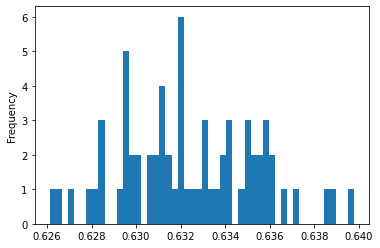

In [ ]:
oof.avg.plot(kind='hist', bins=50) # order_0_model_89 0.639799 - order_2_model_156 0.632451

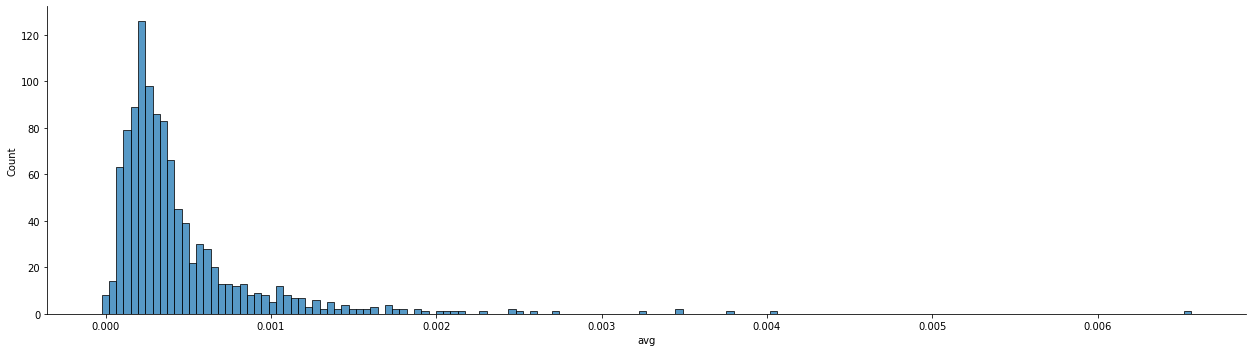

In [96]:
sns.displot(premu_order, x='avg', bins=150, height=5, legend=False,  aspect=3.5)

In [104]:
premu_order.loc[premu_order.avg>0.0001]

,order_0_grid_0_fold_0,order_0_grid_0_fold_1,order_0_grid_0_fold_2,order_0_grid_0_fold_3,order_0_grid_0_fold_4,order_0_grid_1_fold_0,order_0_grid_1_fold_1,order_0_grid_1_fold_2,order_0_grid_1_fold_3,order_0_grid_1_fold_4,...,order_0_grid_3_fold_3,order_0_grid_3_fold_4,order_0_grid_4_fold_0,order_0_grid_4_fold_1,order_0_grid_4_fold_2,order_0_grid_4_fold_3,order_0_grid_4_fold_4,order_0_grid_5_fold_0,order_0_grid_5_fold_1,avg
D_39_last,0.008804,0.004091,5.892178e-03,0.007739,0.006004,7.225527e-03,3.323810e-03,0.005788,6.332243e-03,4.636853e-03,...,0.007927,3.646289e-03,0.008294,0.002583,0.008639,0.009728,5.544698e-03,0.009682,0.002907,0.006565
B_4_std,0.003896,0.002457,2.430127e-03,0.005450,0.006905,4.471331e-03,3.320259e-03,0.003490,5.033725e-03,3.317479e-03,...,-0.001180,3.954205e-03,0.004876,0.002125,0.003555,0.003328,3.987048e-03,0.008408,0.006161,0.004025
D_42_first,0.001916,0.000215,3.750821e-03,0.002813,0.002601,2.695140e-03,2.880462e-03,0.003025,8.210374e-03,1.844617e-03,...,0.002515,4.032709e-03,0.006833,0.002936,0.004062,0.004441,4.274918e-03,0.004878,0.004577,0.003754
D_42_mean,0.006009,0.000592,2.368421e-03,0.004172,0.002840,4.087222e-03,2.271794e-03,0.003455,4.995694e-03,2.944754e-03,...,0.004980,2.073244e-03,0.002735,0.003503,0.003215,0.003678,4.792720e-03,0.003966,0.002872,0.003457
D_42_max,0.003721,0.002839,6.276017e-04,0.004066,0.001144,2.757553e-03,4.023343e-03,0.006319,6.213270e-03,1.636368e-03,...,0.002878,1.215362e-03,0.003460,0.004271,0.002852,0.006660,5.611090e-03,0.004069,0.004370,0.003456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S_16_min,-0.000267,0.000087,1.333393e-03,0.000092,-0.000002,-9.027692e-05,-8.932982e-05,0.000095,-7.441382e-07,8.119506e-04,...,0.000635,2.255245e-07,-0.000370,-0.000284,0.000018,-0.000085,-9.202832e-05,0.000003,-0.000002,0.000103
R_1_mean_m_B_10_mean,0.000555,0.000006,8.926217e-05,0.000447,0.000184,5.614545e-06,1.601025e-06,0.000003,-6.088403e-07,1.804196e-07,...,-0.000003,1.398252e-06,0.000711,0.000804,0.000275,-0.000110,-7.944405e-05,0.000000,0.000002,0.000102
P_2_last_m_R_5_mean,-0.000267,0.000004,-2.480461e-07,0.000089,0.000173,8.793865e-07,2.638308e-06,0.000000,0.000000e+00,0.000000e+00,...,0.000002,0.000000e+00,0.000721,0.000277,-0.000007,-0.000009,1.732979e-03,-0.000001,0.000000,0.000101
D_48_mean_p_R_1_last,0.000729,-0.000010,-5.299166e-06,-0.000092,0.000009,-2.074450e-06,-1.668674e-06,0.000000,1.375528e-06,-1.012605e-05,...,0.000001,-1.932282e-04,0.000187,0.000265,0.000004,0.000093,1.451369e-03,0.000082,-0.000002,0.000101


In [ ]:
premu_save = premu_order.copy()

In [ ]:
parameter        = pd.DataFrame.from_dict(xgb_grid[89], orient='index', columns=['avg'])
parameter['oof'] = pd.DataFrame.from_dict(xgb_grid[156], orient='index', columns=['oof'])['oof']

In [ ]:
parameter['avg'] = pd.DataFrame.from_dict(xgb_grid[92], orient='index', columns=['avg'])['avg']

In [ ]:
feature_order = pd.DataFrame(columns=['order_avg', 'order_oof'])
feature_order['order_avg'] = orders[0]
feature_order['order_oof'] = orders[2]

In [ ]:
parameter.to_csv('/content/drive/MyDrive/KaggleAMEX/Models/freq_1/parameters.csv')

In [ ]:
feature_order.to_csv('/content/drive/MyDrive/KaggleAMEX/Models/freq_1/features.csv')

In [ ]:
# order_1_model_44 0.641124 - order_2_model_156 0.632451
# 13 & not 13
model_metric

0.7931844627660678

# Feature Importance

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

Gain - The relative contribution of the corresponding feature to the model. This is calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

Coverage - The relative number of observations related to this feature. For example, if you have 100 observations, 4 features and 3 trees, and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17 observations. This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features’ cover metrics.

Weight - The percentage representing the relative number of times a particular feature occurs in the trees of the model. In the above example, if feature1 occurred in 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3; then the weight for feature1 will be 2+1+3 = 6. The frequency for feature1 is calculated as its percentage weight over weights of all features.

In [ ]:
importance_types = ['cover', 'gain', 'weight', 'total_gain', 'total_cover']

In [ ]:
df = model.get_score(importance_type='cover')
df = pd.DataFrame.from_dict(df, orient='index', columns = ['cover'])

In [ ]:
df = model.get_score(importance_type='gain')
df = pd.DataFrame.from_dict(df, orient='index', columns = ['gain'])